In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns


# Lab 4: Fire and Tree Mortality

# About the data
Wildfires are increasingly frequent and severe due to climate change. Predicting tree mortality following a wildfire is critical for forest management, ecosystem recovery, and carbon sequestration planning. In this lab, we will build a logistic regression model to predict the probability of tree mortality one year after a wildfire

The database we'll be working with today includes observations of individual trees involved in prescribed fires and wildfires occurring over 35 years, from 1981 to 2016. It is drawn from a fire and tree mortality database from the US Forest Service (see data description for the full database here: [link](https://www.nature.com/articles/s41597-020-0522-7#Sec10)).

The target variable we'll use is `yr1status`, which is a binary variable (0=alive, 1=dead).  This tells us if a tree has died one year after a fire event.

The features we'll use are `YrFireName`, `Times_burned`, `Species`, `Genus_species`,
    `DBH_cm`, `HT_m`, `CR_pre`, and `CR_post`.

## Step 1: Check the metadata

Look at the metadata and provide a description on what each variable represents in the Description column below.


| Feature                     | Description                                                                                   |
|-----------------------------|-----------------------------------------------------------------------------------------------| 
| yr1status                   | If the tree is alive 1 year after a fire.
| YrFireName                  | Name of fire and year that it occured.
| Times_burned                | Number of times a tree burned
| Species                     | PLANTS National database species code, formed by the first two letters of the genus name and first two letters of the species name
| Genus_species               | Full latin name of tree.                                      
| DBH_cm                      | The diameter of the trunk at breast height in centimeters.
| HT_m                        | The height to crown (top of the canopy) before a fire, in meters.
| CR_pre                      | Measure for the volume of living crown (canopy), taken as crown length/tree height as a ratio. Taken before fire.
| CR_post                     | Measure for the volume of living crown (canopy), taken as crown length/tree height as a ratio. Taken after fire.

## Step 2: Fetch  data
Read in the data set and filter to retain only the variables of interest.  Then check for incomplete observations and remove any rows containing NaNs.  How many observations does that leave us with? **Print your answer.**

That leaves us with 36509 observations.

In [2]:
# Load and subset the dataset
trees_dat = (pd.read_csv(
             '/courses/EDS232/Data/FTM_trees.csv', 
             low_memory = False   # mediates potential type errors
            )
             [['yr1status','YrFireName', 'Times_burned', 'Species', 'Genus_species', 'DBH_cm', 'HT_m', 'CR_pre', 'CR_post']]
            )

# Count NANs
trees_dat.isna().sum()

yr1status         33263
YrFireName            0
Times_burned          0
Species               0
Genus_species         0
DBH_cm             3973
HT_m              61650
CR_pre           119342
CR_post          130605
dtype: int64

In [3]:
# drop NANs
trees_dat_clean = trees_dat.dropna()

# Output number of observations
print(f'Observation count: {trees_dat_clean.shape[0]}')

Observation count: 36509


## Step 3: Data Preprocessing
1. We recode categorical predictors to zero-based integer form because most machine learning models, including logistic regression, cannot work directly with categorical data represented as strings or labels. Instead, models require numerical input. Let's do that here. 


In [4]:
# convert char format categorical data to numeric
trees_dat_num = (trees_dat_clean
                 .replace(trees_dat_clean['Species'].unique(), list(range(0, len(trees_dat_clean.Species.unique()))))
                 .replace(trees_dat_clean['YrFireName'].unique(), list(range(0, len(trees_dat_clean.YrFireName.unique()))))
                 .replace(trees_dat_clean['Genus_species'].unique(), list(range(0, len(trees_dat_clean.Genus_species.unique())))))

2. Then we'll split into training and test data and scale for coefficient interpretability.  Recall that we use the training features to calculate our scaling parameters (mean and standard deviation) and apply the scaling to those training features (`scaler.fit_transform`) and then apply the scaling to the features in the test data as well (`scaler.transform`).


In [5]:
y = trees_dat_num.iloc[:, :1] # select first column (dependant)
x = trees_dat_num.iloc[:, 1:] # select rest of columns (predictors)

# split training/test data 70/30
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

# normalize data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

3. How many training/test observations do we have? Print your answer in the cell below. 

In [7]:
# Verify the training and testing set size
print("Training set observations:", x_train_scaled.shape[0])
print("Testing set observations:", x_test_scaled.shape[0])

Training set observations: 25556
Testing set observations: 10953


## Step 4: Train a Logistical Model
Create a classifier using `LogisticRegression()` and fit it on the training data.  Then assess the model's accuracy on the training set by making predictions on the training data.  Calculate and **print** the accuracy of your model on the training set. 

In [8]:
# train model
model = LogisticRegression().fit(x_train_scaled, y_train.values.ravel())

# predict value based on training data
y_pred_train = model.predict(x_train_scaled)

# get model accuracy
accuracy = accuracy_score(y_train, y_pred_train)

print(f"Accuracy: {accuracy:.3f}")


Accuracy: 0.944


## Step 5: Test Set Predictions and Model Evaluation
Now let's take our trained logistic classifier and make predictions on the test set. Calculate the accuracy and confusion matrix. Then use `sns.heatmap` for improved confusion matrix visualization.

Accuracy: 0.9393


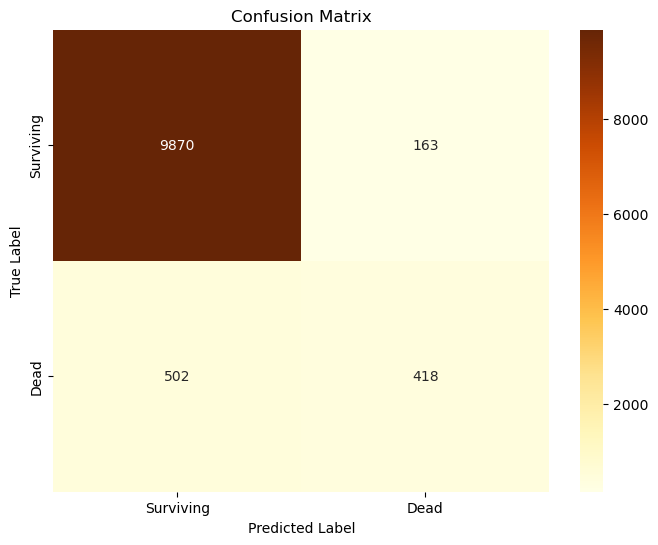

In [9]:
# predict values with test data
y_pred_test = model.predict(x_test_scaled)

# init confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)

# assign cm values
TP = cm_test[1,1] # true positive
TN = cm_test[0,0] # true negative
FP = cm_test[0,1] # false positive
FN = cm_test[1,0] # false negative

# compute model accuracy
accuracy = (TN + TP)/(TP + TN + FP + FN)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")

#Plot confusion matrix
plt.figure(figsize = (8,6))
sns.heatmap(cm_test, 
            fmt = 'd', # specify whole integer format for value labels
            cmap = sns.color_palette("YlOrBr", as_cmap=True), 
            annot = True, 
            xticklabels = ['Surviving', 'Dead'], 
            yticklabels = ['Surviving', 'Dead'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Step 6: Logistic Classifier Evaluation
How did your model perform on the unseen data? 
Does your model perform differently on observations of trees that survived vs trees that died?
Is there a class imbalance in this data set?

The both models have essentially the same rate of accuracy. Because trees surviving is such a common event when a fire occurs, the model may be ignoring the alternative. When calculating the models accuracy of either predicting dead or surviving trees individually, it seems that it predicts the more common event better than the less common event. This is due to a class imbalance between the dead and surviving trees.

In [10]:
# calculate accuracy of predicting dead trees (sensitivity)
dead_accuracy = TP / (TP + FN)

# calculate accuracy of predicting surviving trees (specificity)
surviving_accuracy = TN / (TN + FP)

print(f'Accuracy of predicting dead trees: {dead_accuracy:.3f}')
print(f'Accuracy of predicting surviving trees: {surviving_accuracy:.3f}')

Accuracy of predicting dead trees: 0.454
Accuracy of predicting surviving trees: 0.984


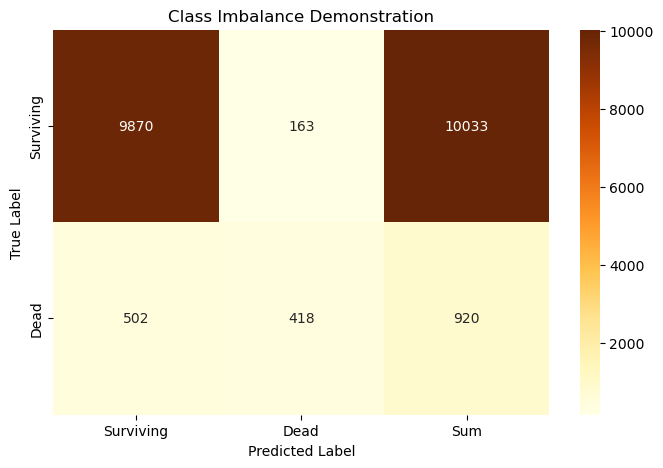

In [11]:
# Append sums to matrix rows than join
line1 = np.append(cm_test[0], cm_test[0,0] + cm_test[0,1])
line2 = np.append(cm_test[1], cm_test[1,0] + cm_test[1,1])

# append rows top down to form matrix
class_imbalance = np.stack([line1, line2])

# demonstrate class imbalance
plt.figure(figsize = (8,5))
sns.heatmap(class_imbalance, 
            fmt = 'd', # specify whole integer format for value labels
            cmap = sns.color_palette("YlOrBr", as_cmap=True), 
            annot = True, 
            xticklabels = ['Surviving', 'Dead', 'Sum'], 
            yticklabels = ['Surviving', 'Dead'])
plt.title('Class Imbalance Demonstration')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Step 7: What about a Dummy?
What do you think would happen if we built a model that always predicts the majority class (dead trees)? How would its accuracy compare to your logistic regression model?

It would still predict successfully about 92% of the time, which is similar to our logistic regression model.

In [12]:
# calculate predicted accuracy of dummy variable
dummy_acc = len(trees_dat_num[trees_dat_num['yr1status'] == 0]) / len(trees_dat_num['yr1status'])

print(f'Predicted accuracy with dummy variable: {dummy_acc:.2f}')

Predicted accuracy with dummy variable: 0.92


Let's go ahead and do it: use `DummyClassifier()` with the appropriate value for the 'strategy' parameter to train a majority classifier.  Then calculate this model's accuracy on the training data.

Dummy Accuracy: 0.9160047475577467

Dummy Confusion Matrix:


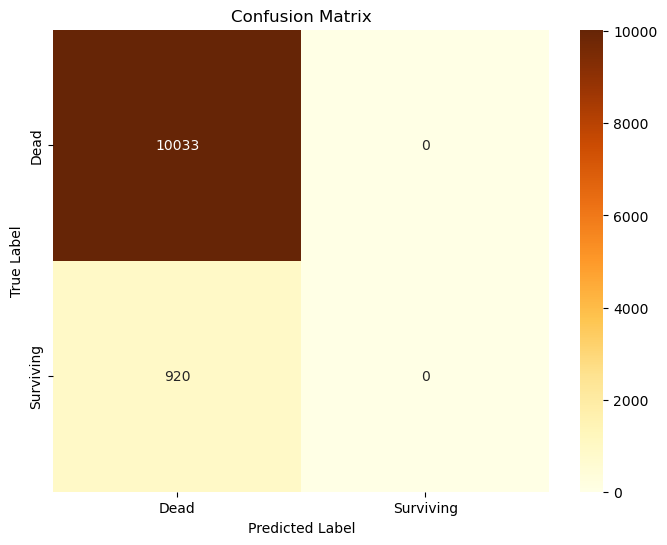

In [13]:
# create dummy model
dummy = DummyClassifier(strategy = 'most_frequent').fit(x_train_scaled, y_train)

# get dummy variable values
dum_y_pred_test = dummy.predict(x_test_scaled)

# init confusion matrix
cm_dummy = confusion_matrix(y_test, dum_y_pred_test)

# assign values
TP = cm_dummy[1,1] # true positive
TN = cm_dummy[0,0] # true negative
FP = cm_dummy[0,1] # false positive
FN = cm_dummy[1,0] # false negative

# calculate model accuracy
dum_accuracy = (TN + TP)/(TP + TN + FP + FN)

# Print accuracy and confusion matrix results
print(f"Dummy Accuracy: {dum_accuracy}")
print("\nDummy Confusion Matrix:")

# Plot confusion matrix
plt.figure(figsize = (8,6))
sns.heatmap(cm_dummy, 
            fmt = 'd', # specify whole integer format for value labels
            cmap = sns.color_palette("YlOrBr", as_cmap=True), 
            annot = True, 
            xticklabels = ['Dead', 'Surviving'], 
            yticklabels = ['Dead', 'Surviving'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Step 8: ROCs and AUCs
Our two models have similar accuracy, but is that all there is to this story?  Let's dig a little deeper on the comparison of our logistic and dummy classifiers by examining the associated receiver-operator characteristic (ROC) curves. Calculate the area under the curve (AUC) for both models.

In [14]:
# Logistic classifier AUC
y_pred_probs_log = model.predict_proba(x_test_scaled)[:,1]

# calculate roc values for logistic regression model
fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_probs_log)

# calculate area under curve
auc_log = auc(fpr_log, tpr_log)

print(f"Logistic AUC: {auc_log:.2f}")

Logistic AUC: 0.90


In [15]:
# Dummy classifier AUC
y_pred_probs_dum = dummy.predict_proba(x_test_scaled)[:,1]

# calculate roc values for dummy model
fpr_dum, tpr_dum, _ = roc_curve(y_test, y_pred_probs_dum)

# calculate area under curve
auc_dum = auc(fpr_dum, tpr_dum)

print(f"Dummy AUC: {auc_dum}")

Dummy AUC: 0.5


# Step 9: Plot dummy and logistic model ROC curves
Now using the outputs from `roc_curve()`, plot the ROC curves for both models on the same plot.  Make sure to use appropriate labels in the legend.

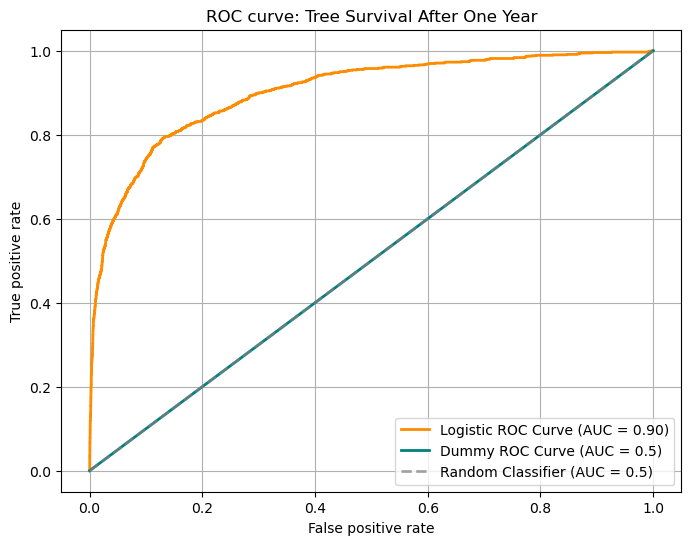

In [16]:
# plot roc curve
plt.figure(figsize = (8,6))
plt.plot(fpr_log, tpr_log, color = 'darkorange', lw = 2, label = f"Logistic ROC Curve (AUC = {auc_log:.2f})")
plt.plot(fpr_dum, tpr_dum, color = 'teal', lw = 2, label = f'Dummy ROC Curve (AUC = {auc_dum:.1f})')
plt.plot([0,1], [0,1], color = 'grey', lw = 2, linestyle = '--',
         label = 'Random Classifier (AUC = 0.5)', alpha = 0.7)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve: Tree Survival After One Year')
plt.legend()
plt.grid(True)
plt.show()

How do the two models compare on AUC?  What are the implications for evaluating classifiers based on accuracy of their predictions?

The logistic model has a AUC that's a lot better than random guessing, while the dummy model is only as good as randomly guessing. This is because for the dummy model, this is essentially what you are doing, just in a way that maximizes accuracy, as if I were to randomly generate 1s and 0s, it is more likely that my accuracy would be lower than just guessing all 0s. Even though the dummy model technically has a higher accuracy, it still remains functionally useless because any human can guess a 0 every time. The logistic model is more useful for this reason.

# Step 10: Final interpretation

Identifying the most important features in a model can guide decision-making. For instance, in our dataset, highly important features might indicate key factors affecting tree survival after a fire. We will calculate the feature importance by examining the coefficients of our logistic regression model.

In [17]:
importance_df = (pd.DataFrame(index = x.columns, 
                              data = {'Coefficients': model.coef_[0]})
                 .sort_values(by = 'Coefficients', 
                              key = lambda x: abs(x), # sort by absolute value 
                              ascending = False))

# Print the sorted feature importance
print(importance_df)

               Coefficients
CR_post           -2.268484
HT_m              -0.996278
DBH_cm             0.413430
Genus_species      0.180301
Species            0.180301
YrFireName        -0.133544
CR_pre             0.026231
Times_burned       0.000000


Which are the most important features in our model (reference the metadata to help answer this)? Can you think of any implications for forest management or conservation strategy?

The volume of living crown after a fire is by far the most important feature, with height to crown being a strong runner up. Trunk diameter and species are also possibly important to a lesser extent. With this said, a possible forest management strategy may be thinning the forest to protect large trees which are more likely to survive a fire, or thinning trees with low canopy after a fire has occured so new trees can grow.